# Caricamento dei dati

## Tabella delle trame

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.2")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.plots") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.plots") \
    .getOrCreate()

plots_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
plots_df.show()

+---------+--------------------+--------------------+
|      _id|       plot_synopsis|               title|
+---------+--------------------+--------------------+
|tt0000091|The film opens wi...| Le manoir du diable|
|tt0000225|A widower merchan...| La belle et la bête|
|tt0000230|A prologue in fro...|          Cendrillon|
|tt0000417|At a meeting of t...|Le voyage dans la...|
|tt0000488|Joe is an impover...|The Land Beyond t...|
|tt0000634|Mark Antony – one...|Antony and Cleopatra|
|tt0000709|The play opens wi...|       Julius Caesar|
|tt0000966|The play consists...|A Midsummer Night...|
|tt0001223|The film starts w...|        Frankenstein|
|tt0001227|Dr. Richard Kimbl...|        The Fugitive|
|tt0001724|Two men who are f...|The Last Drop of ...|
|tt0001915|=== Book the Firs...|A Tale of Two Cities|
|tt0002130|The exhumation of...|           L'Inferno|
|tt0003419|Being praised as ...|Der Student von Prag|
|tt0003489|In Pompeii 79AD, ...|Gli ultimi giorni...|
|tt0004022|The play opens wi

## Join con tabella dei generi

In [2]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.tags") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.tags") \
    .getOrCreate()
tags = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

tags_df = tags.join(plots_df, tags._id == plots_df._id, how='inner').select(tags._id, 'title', 'plot_synopsis', 'tags')
tags_df.show()

+---------+--------------------+--------------------+--------------------+
|      _id|               title|       plot_synopsis|                tags|
+---------+--------------------+--------------------+--------------------+
|tt0021156|             Morocco|The film is set i...|   revenge, romantic|
|tt0032553|  The Great Dictator|During a battle i...|comedy, anti war,...|
|tt0034269|               Texas|Two Confederate v...|    romantic, murder|
|tt0038958|   So Dark the Night|So Dark the Night...|              murder|
|tt0039305|      Dead Reckoning|Leaving a church,...|plot twist, murde...|
|tt0039431|           Good News|The film is set i...|       psychological|
|tt0039896|They Won't Believ...|After the prosecu...|   murder, flashback|
|tt0042475| A Fractured Leghorn|The cat is fishin...|         psychedelic|
|tt0042899|      Rocky Mountain|A car pulls up to...|            violence|
|tt0043973|           Roadblock|Insurance investi...|              murder|
|tt0052811|The Flesh and 

## Join con tabella per divisione training-test

In [3]:
from pyspark.sql.types import *

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.metadata") \
    .getOrCreate()
traintest_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_tt_df = tags_df.join(traintest_df, tags_df._id == traintest_df._id, how='inner')\
    .select(tags._id, 'title', 'plot_synopsis', 'tags', 'split')
joined_tt_df.show()

+---------+--------------------+--------------------+--------------------+-----+
|      _id|               title|       plot_synopsis|                tags|split|
+---------+--------------------+--------------------+--------------------+-----+
|tt0021156|             Morocco|The film is set i...|   revenge, romantic|train|
|tt0032553|  The Great Dictator|During a battle i...|comedy, anti war,...|train|
|tt0034269|               Texas|Two Confederate v...|    romantic, murder|  val|
|tt0038958|   So Dark the Night|So Dark the Night...|              murder|train|
|tt0039305|      Dead Reckoning|Leaving a church,...|plot twist, murde...| test|
|tt0039431|           Good News|The film is set i...|       psychological|train|
|tt0039896|They Won't Believ...|After the prosecu...|   murder, flashback|train|
|tt0042475| A Fractured Leghorn|The cat is fishin...|         psychedelic| test|
|tt0042899|      Rocky Mountain|A car pulls up to...|            violence|train|
|tt0043973|           Roadbl

# Analisi preliminare tag/generi

## Conteggio dei film per genere

In [4]:
genres = joined_tt_df.rdd\
    .map(lambda x: (x.tags))\
    .flatMap(lambda x: [genre for genre in x.split(', ')])

ordered_genres = genres\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()
ordered_genres.sort(key=lambda x: x[1], reverse=True)
ordered_genres[:10]

[('murder', 5782),
 ('violence', 4426),
 ('flashback', 2937),
 ('romantic', 2906),
 ('cult', 2647),
 ('revenge', 2468),
 ('psychedelic', 1897),
 ('comedy', 1859),
 ('suspenseful', 1086),
 ('good versus evil', 875)]

## Grafico

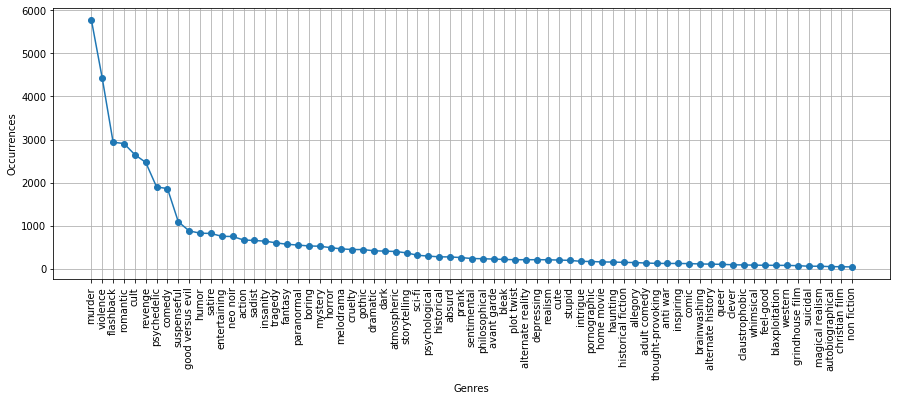

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in ordered_genres], [x[1] for x in ordered_genres], marker='o')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Occurrences')
plt.show()

# Trasformazione dei generi da stringa ad array

In [6]:
genres_split_df = joined_tt_df.rdd\
    .map(lambda x: (x[0], x[1], x[2], x[3].split(', '), x[4]))\
    .toDF(['id', 'title', 'plot', 'genres', 'split'])
genres_split_df.show()

+---------+--------------------+--------------------+--------------------+-----+
|       id|               title|                plot|              genres|split|
+---------+--------------------+--------------------+--------------------+-----+
|tt0021156|             Morocco|The film is set i...| [revenge, romantic]|train|
|tt0032553|  The Great Dictator|During a battle i...|[comedy, anti war...|train|
|tt0034269|               Texas|Two Confederate v...|  [romantic, murder]|  val|
|tt0038958|   So Dark the Night|So Dark the Night...|            [murder]|train|
|tt0039305|      Dead Reckoning|Leaving a church,...|[plot twist, murd...| test|
|tt0039431|           Good News|The film is set i...|     [psychological]|train|
|tt0039896|They Won't Believ...|After the prosecu...| [murder, flashback]|train|
|tt0042475| A Fractured Leghorn|The cat is fishin...|       [psychedelic]| test|
|tt0042899|      Rocky Mountain|A car pulls up to...|          [violence]|train|
|tt0043973|           Roadbl

# Inserimento delle valutazioni dei film nella tabella delle trame

## Caricamento dei metadati

In [7]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .getOrCreate()
metadata = spark.read.format("com.mongodb.spark.sql.DefaultSource").load().select(['_id', 'title', 'vote_average'])

metadata.show()

+-----+--------------------+------------+
|  _id|               title|vote_average|
+-----+--------------------+------------+
|  862|           Toy Story|         7.7|
| 8844|             Jumanji|         6.9|
|15602|    Grumpier Old Men|         6.5|
|31357|   Waiting to Exhale|         6.1|
|11862|Father of the Bri...|         5.7|
|  949|                Heat|         7.7|
|11860|             Sabrina|         6.2|
|45325|        Tom and Huck|         5.4|
| 9091|        Sudden Death|         5.5|
|  710|           GoldenEye|         6.6|
| 9087|The American Pres...|         6.5|
|12110|Dracula: Dead and...|         5.7|
|21032|               Balto|         7.1|
|10858|               Nixon|         7.1|
| 1408|    Cutthroat Island|         5.7|
|  524|              Casino|         7.8|
| 4584|Sense and Sensibi...|         7.2|
|    5|          Four Rooms|         6.5|
| 9273|Ace Ventura: When...|         6.1|
|11517|         Money Train|         5.4|
+-----+--------------------+------

## Join con la tabella delle trame

In [8]:
ids_joined = genres_split_df.join(metadata, genres_split_df.title == metadata.title, how='inner')
print(ids_joined.count())
ids_joined.show()

13417
+---------+--------------------+--------------------+--------------------+-----+------+--------------------+------------+
|       id|               title|                plot|              genres|split|   _id|               title|vote_average|
+---------+--------------------+--------------------+--------------------+-----+------+--------------------+------------+
|tt0060048|40 Guns to Apache...|In the Arizona Te...|          [violence]|train| 38680|40 Guns to Apache...|         4.1|
|tt0066050| A Man Called Sledge|Luther Sledge (Ga...|          [violence]|train| 70387| A Man Called Sledge|         6.5|
|tt0034399|      A Woman's Face|Set in Sweden, th...|[flashback, suspe...| test| 27622|      A Woman's Face|         6.1|
|tt0034399|      A Woman's Face|Set in Sweden, th...|[flashback, suspe...| test| 76848|      A Woman's Face|         6.0|
|tt0488085|         Big Nothing|The film is set i...|[dark, comedy, ne...| test|  9843|         Big Nothing|         6.5|
|tt0415679|       

# Caricamento delle stopword

In [9]:
stopwords = set()
for line in open('stopwords.txt'):
    stopwords.add(line.strip())
stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'away',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'computer',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fify',
 'fill',
 'find',
 'fire',
 'fi

# Parole più usate per genere per i film con valutazioni alte

## Calcolo

In [10]:
only_genres = [genretuple[0] for genretuple in ordered_genres] # Ordina i generi in una lista per poter usare il for
threshold_vote = 7.5
words_dict = {}

for gen in only_genres:
    gen_words = ids_joined.rdd\
        .filter(lambda x: gen in x.genres)\
        .filter(lambda x: x.split == 'train')\
        .filter(lambda x: x.vote_average >= threshold_vote)\
        .map(lambda x: x.plot.replace(',', ' ').replace('.', ' ').replace('-', ' ')\
        .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
        .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
        .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower())\
        .flatMap(lambda x: x.split())\
        .filter(lambda x: len(x) > 2)\
        .map(lambda x: (x.strip(), 1))\
        .filter(lambda x: x[0] not in stopwords)
    gen_occurrences = gen_words.reduceByKey(lambda x, y: x + y).collect()
    gen_occurrences.sort(key=lambda x: x[1], reverse=True)
    words_dict[gen] = gen_occurrences # Inserisci il dizionario dei termini in un dizionario dei generi

## Grafico

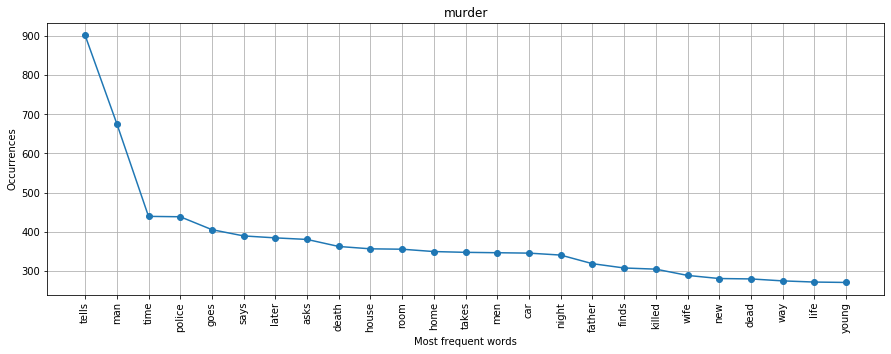

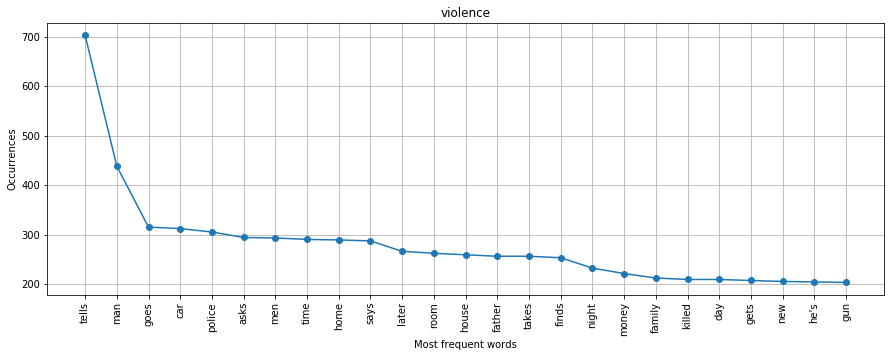

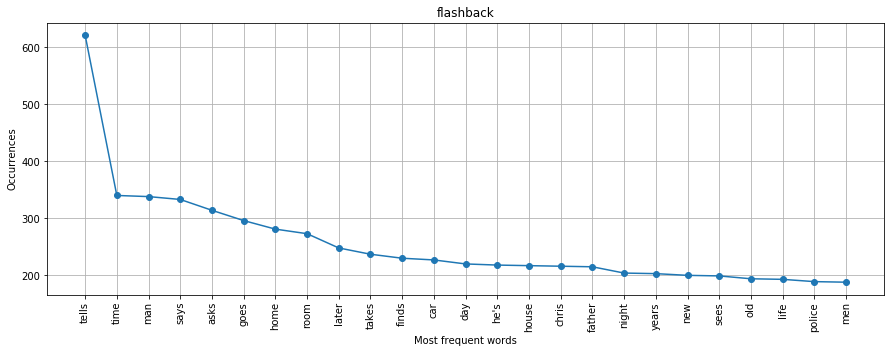

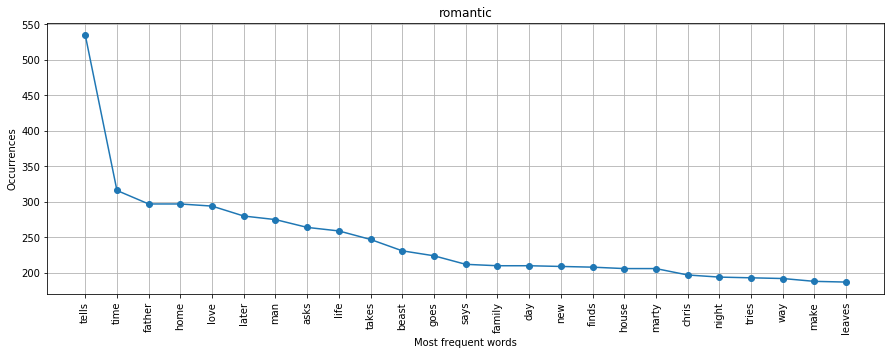

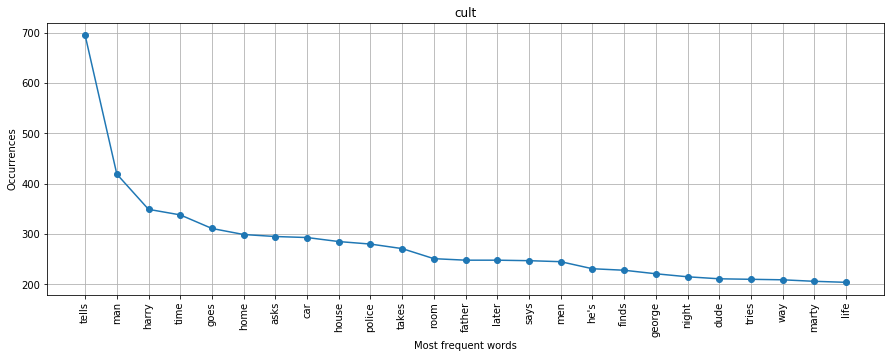

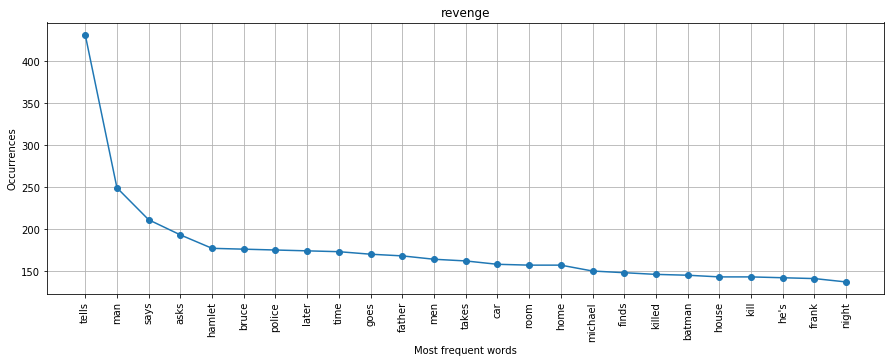

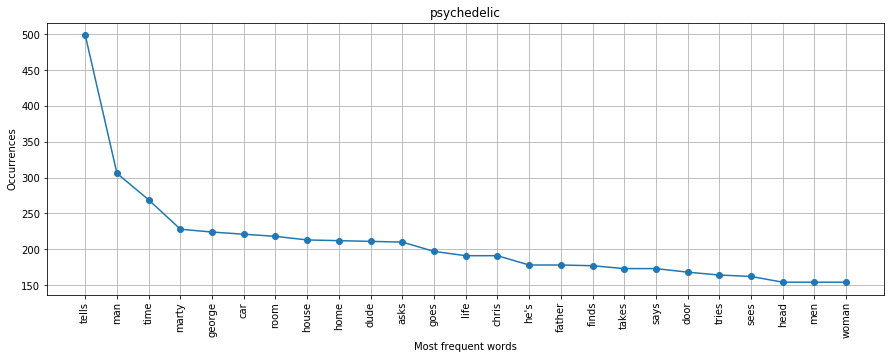

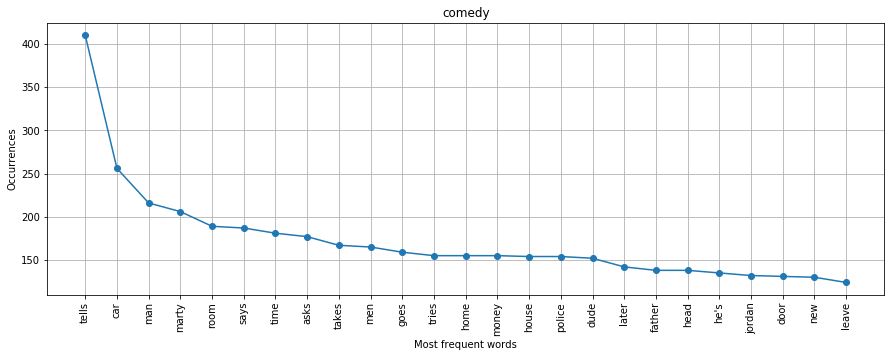

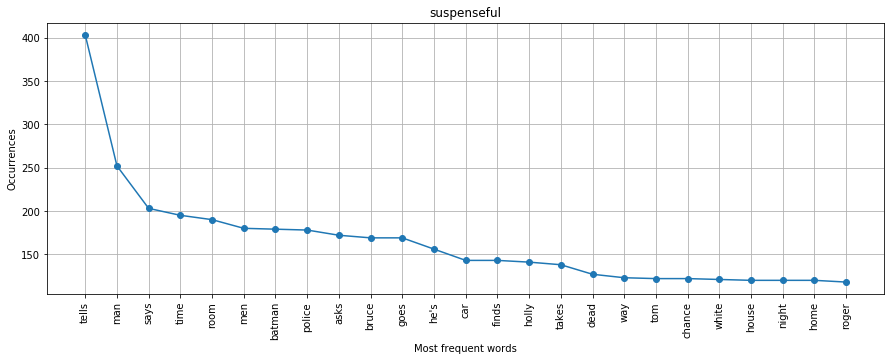

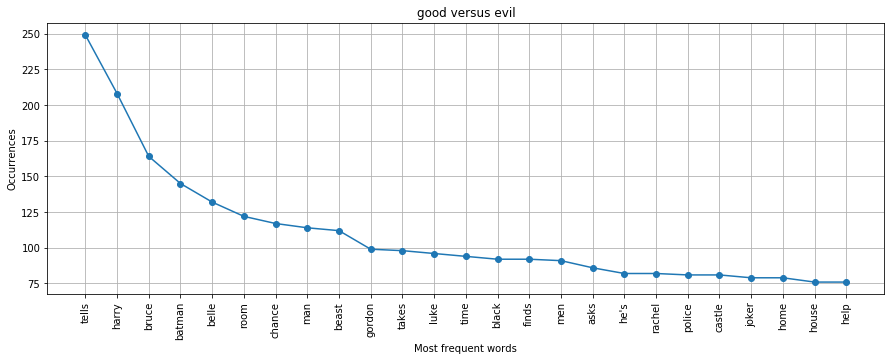

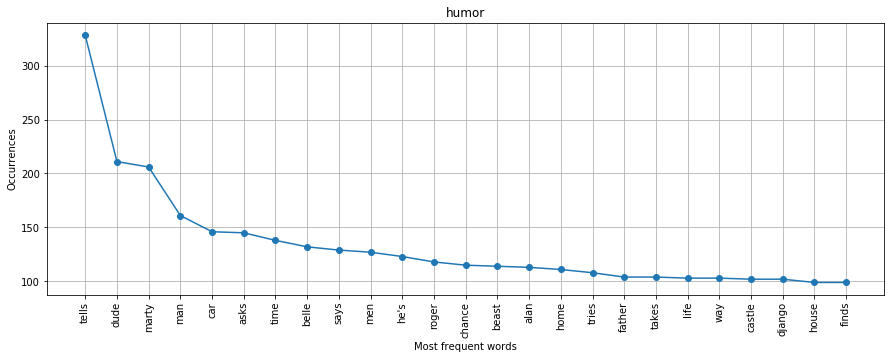

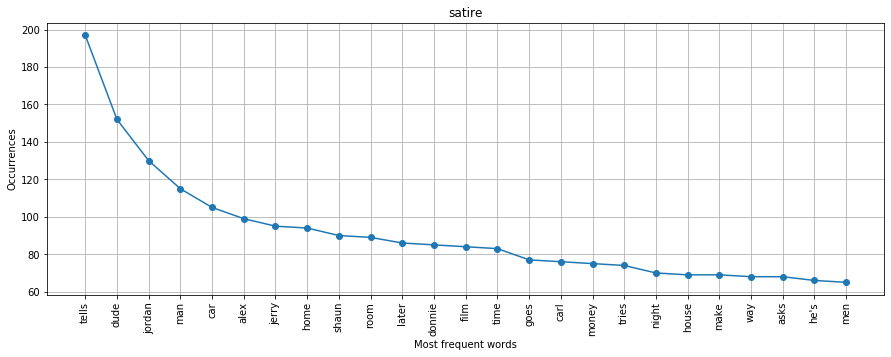

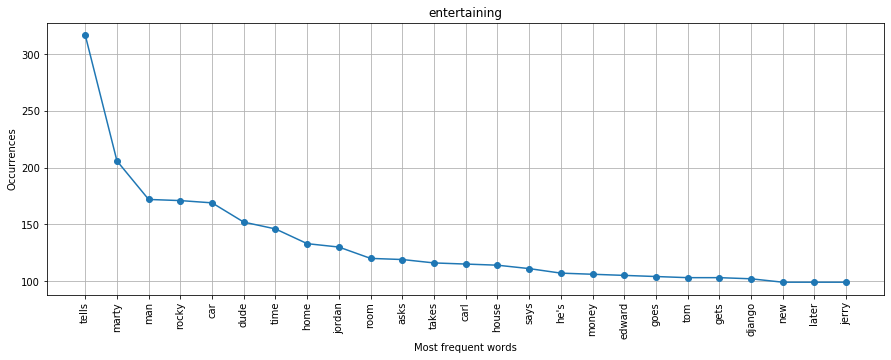

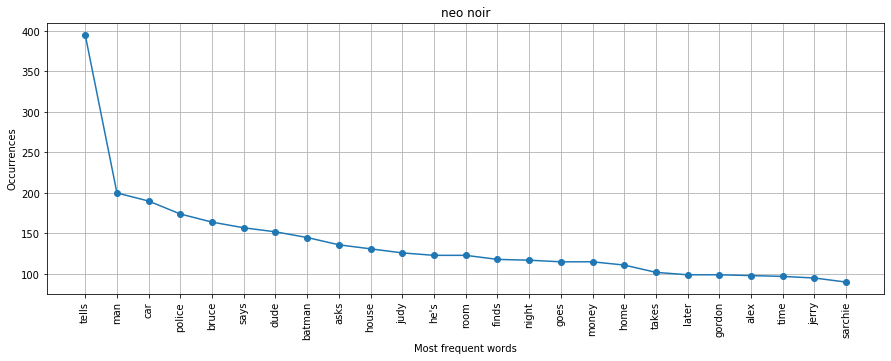

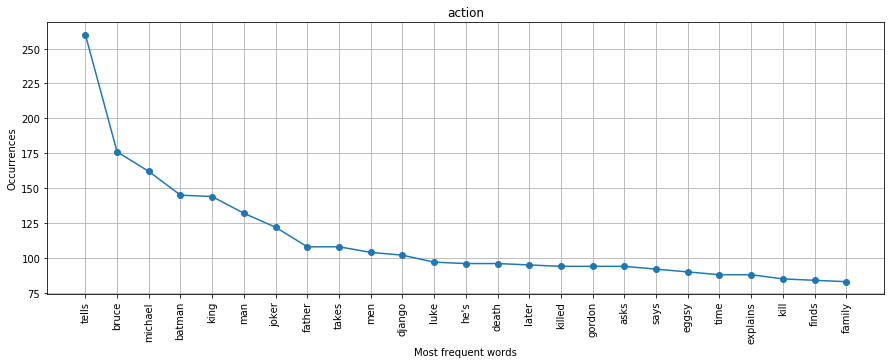

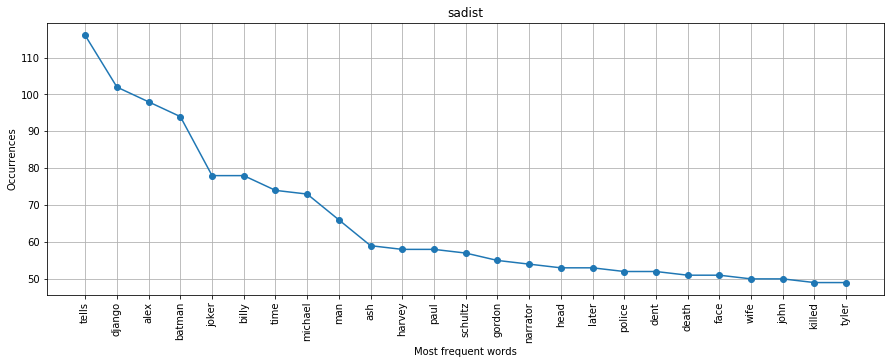

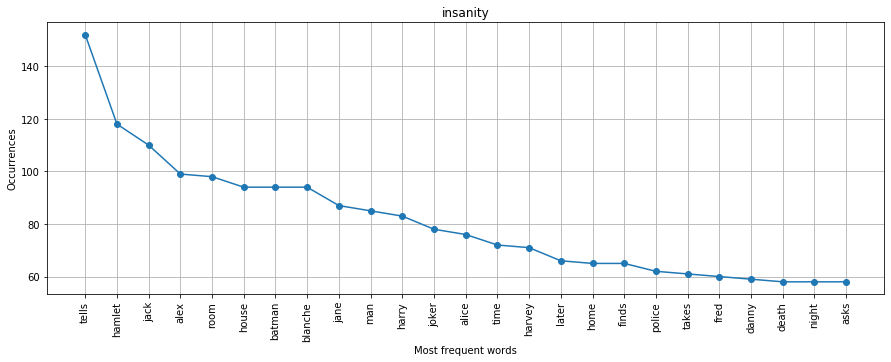

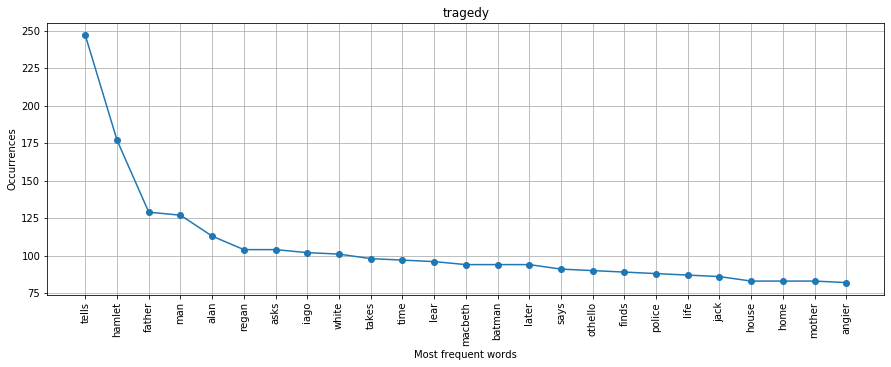

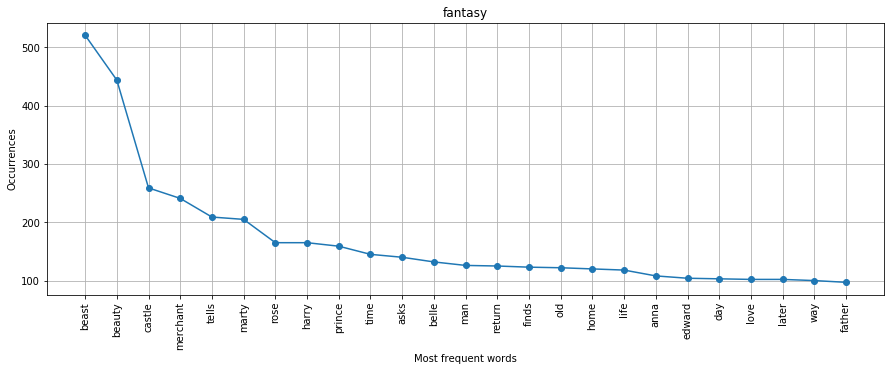

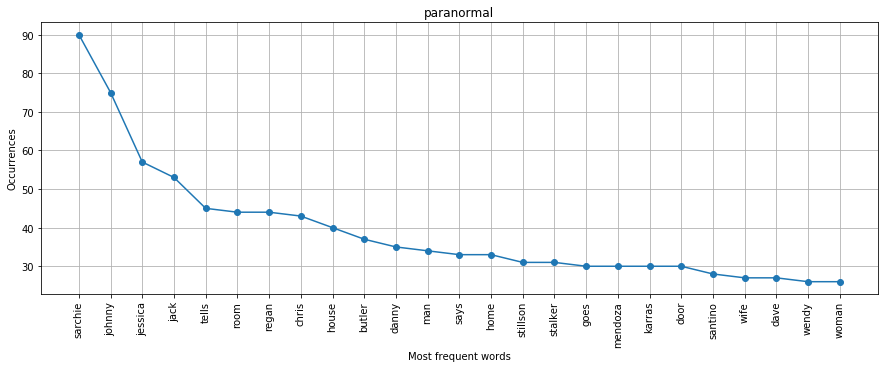

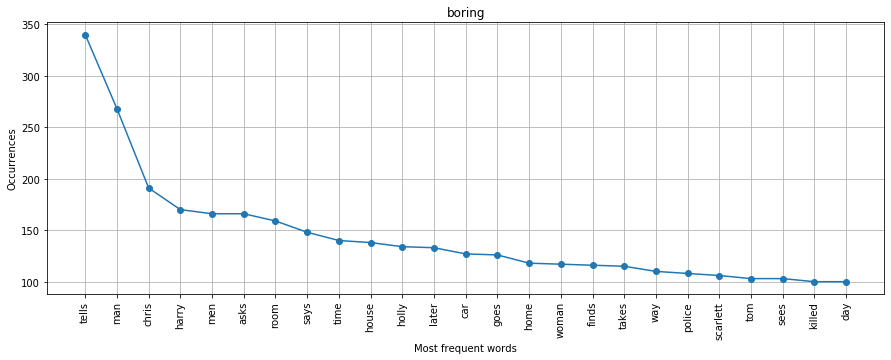

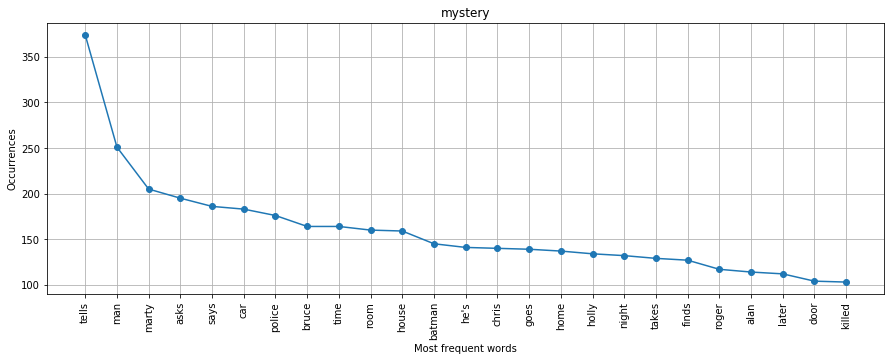

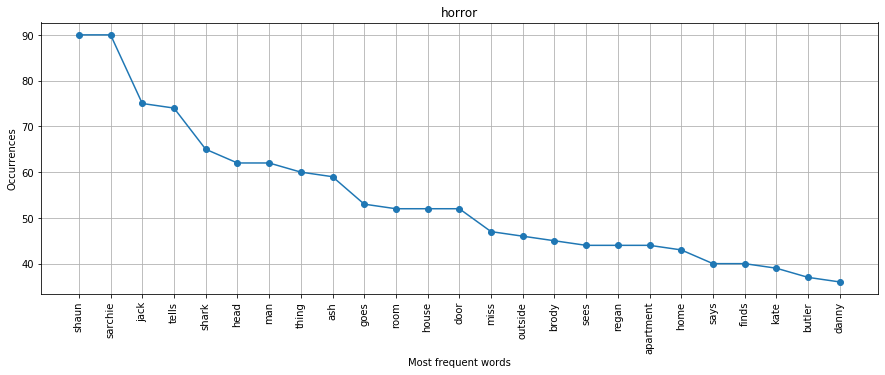

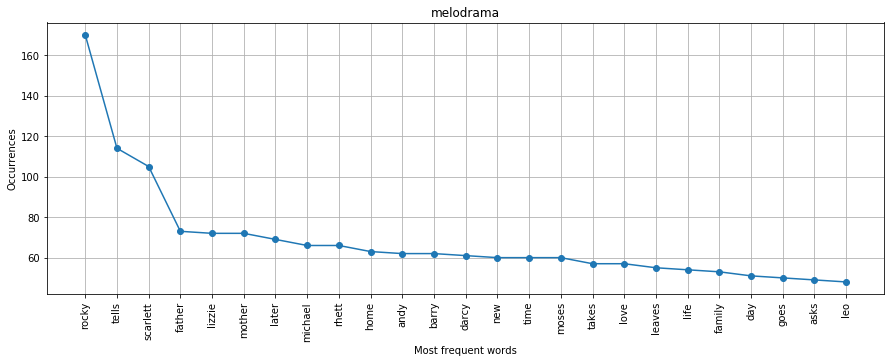

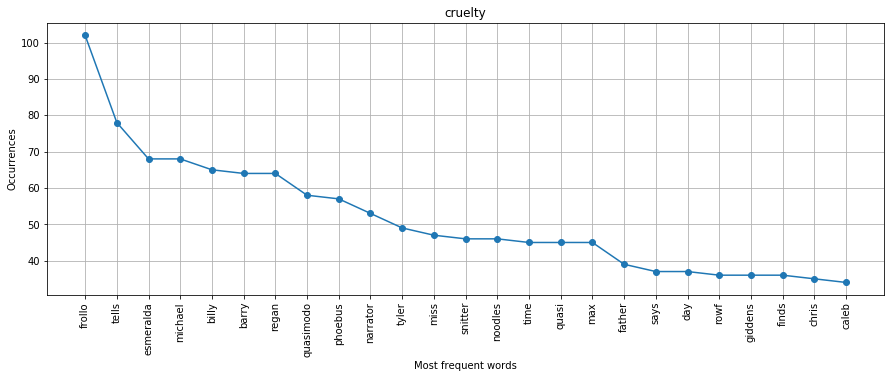

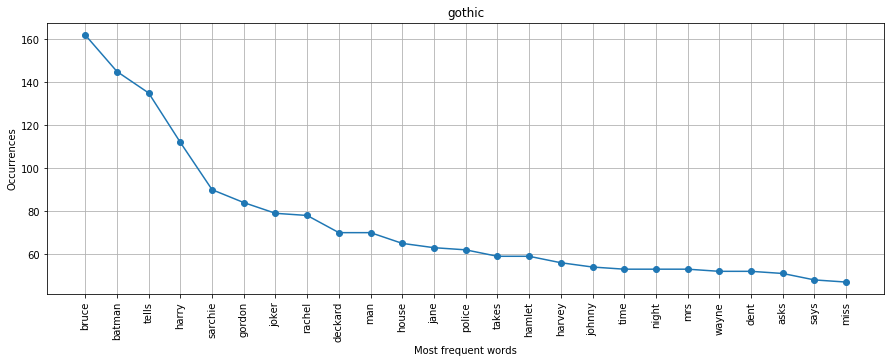

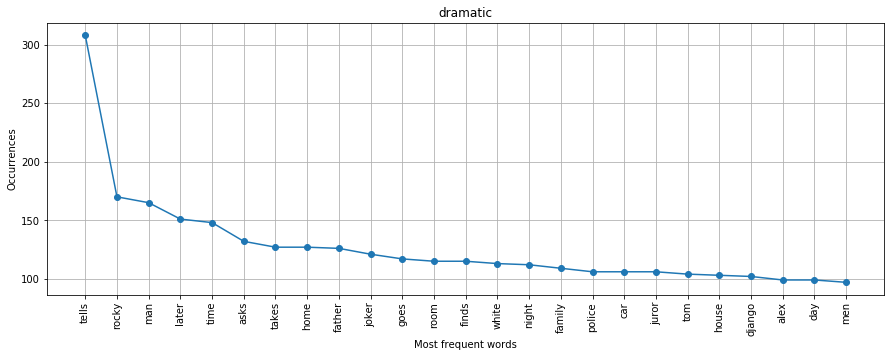

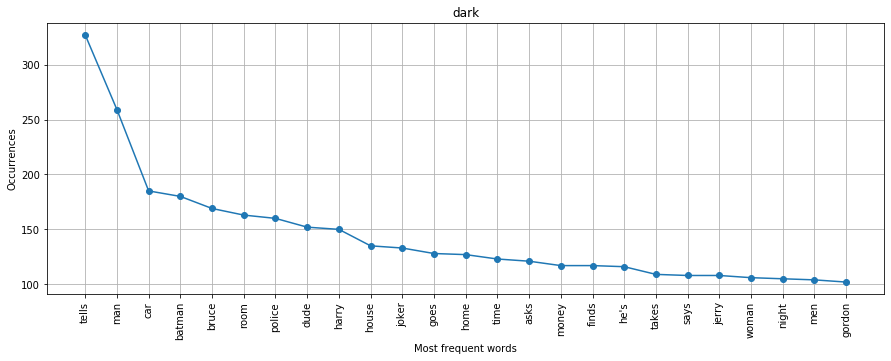

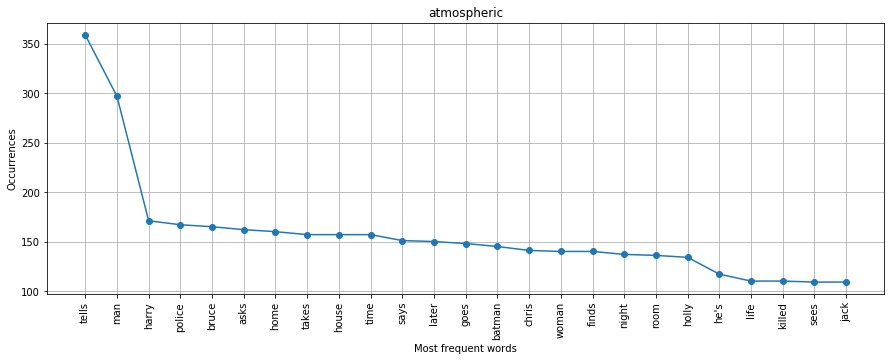

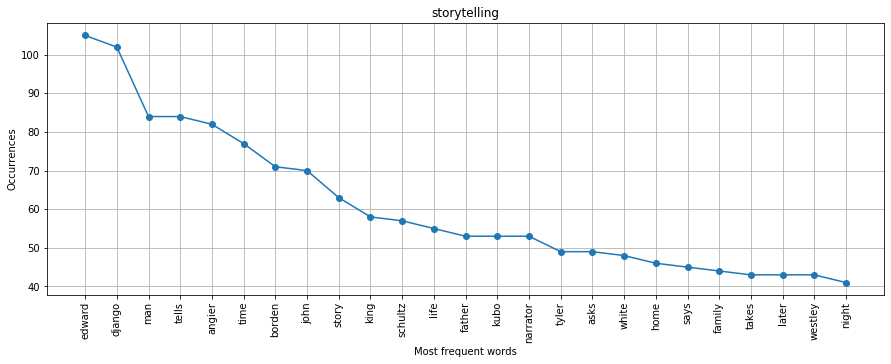

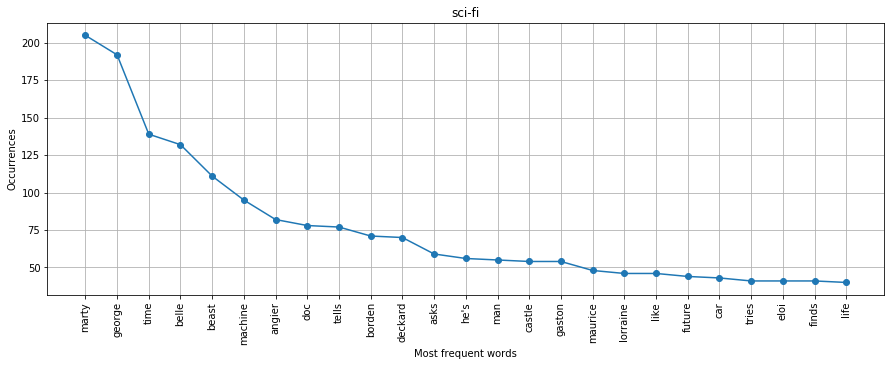

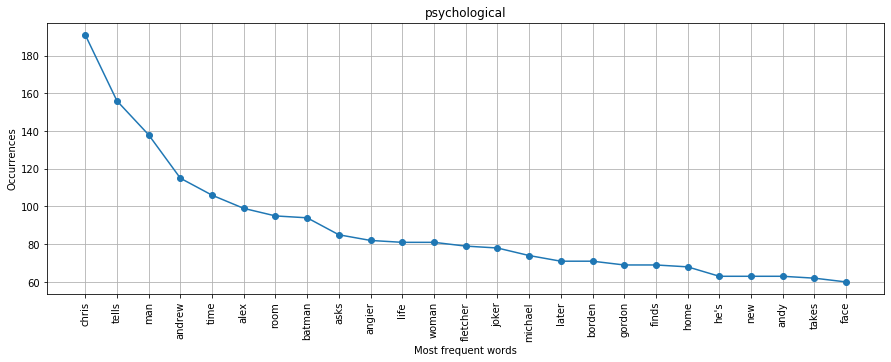

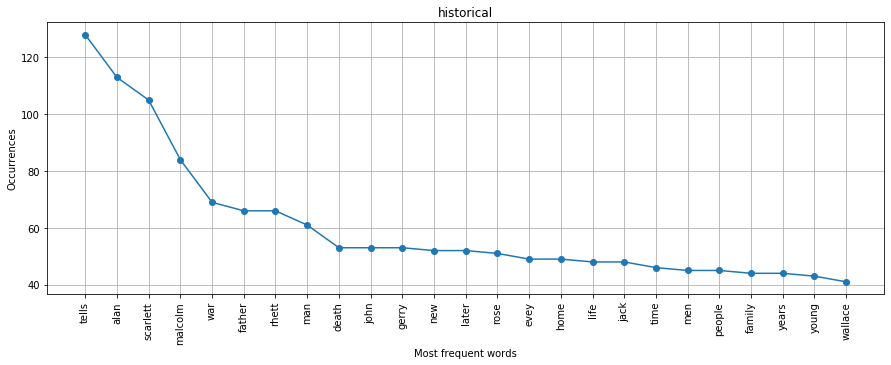

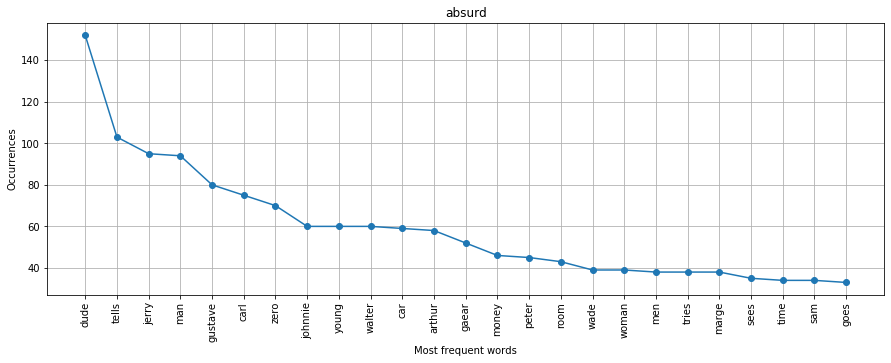

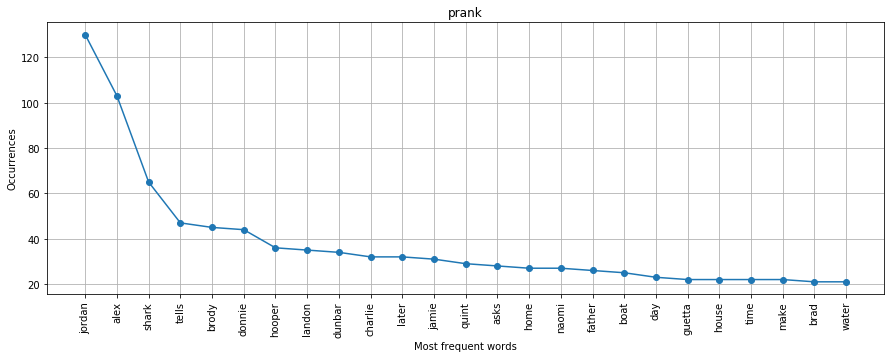

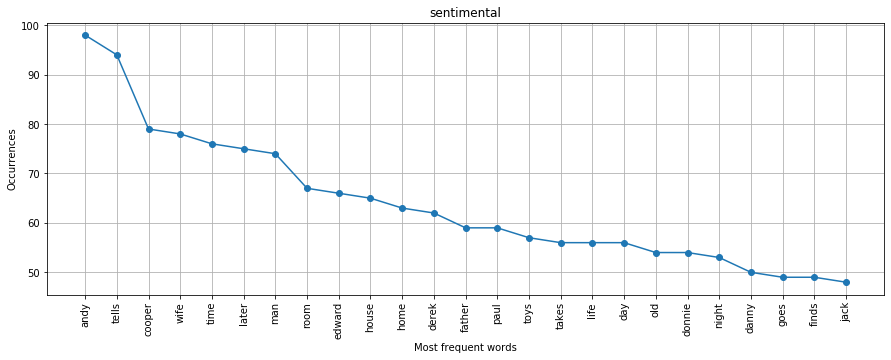

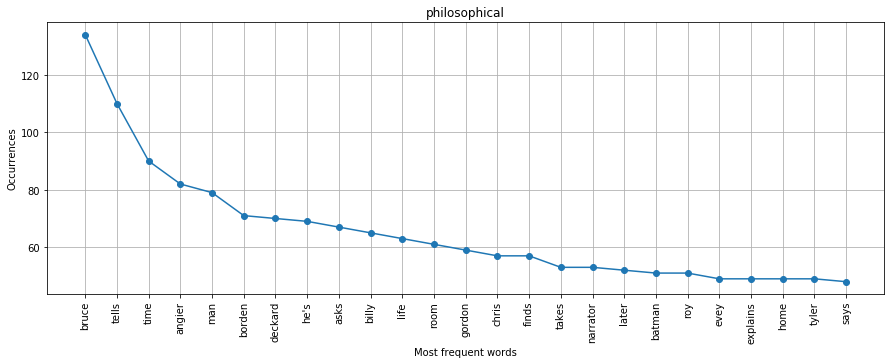

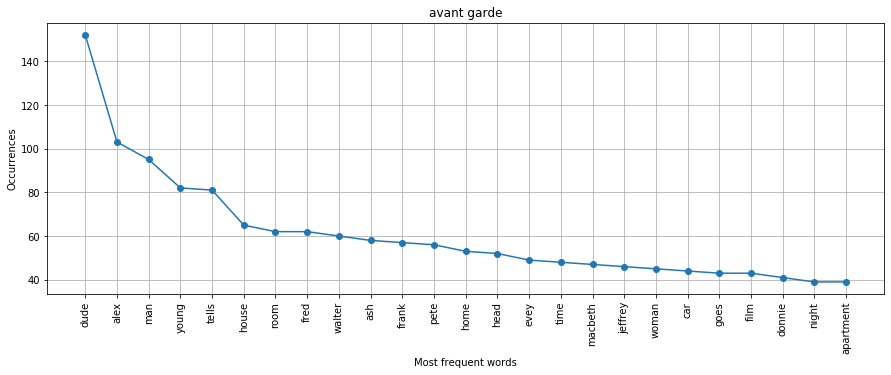

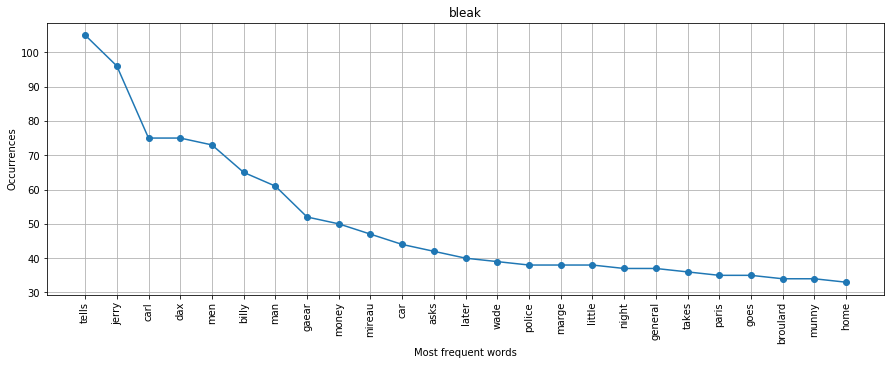

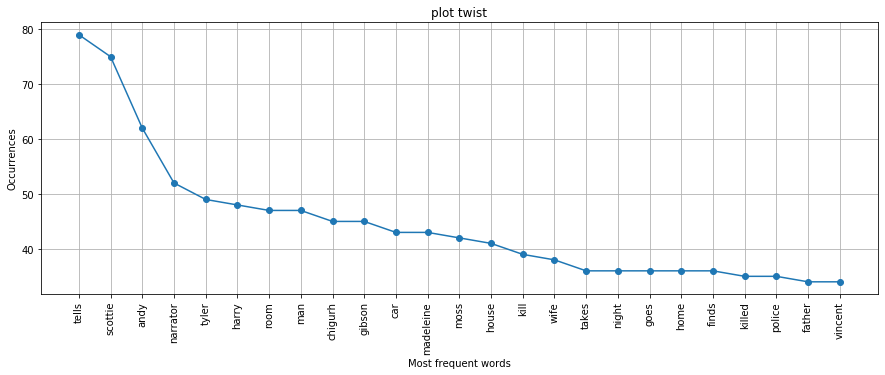

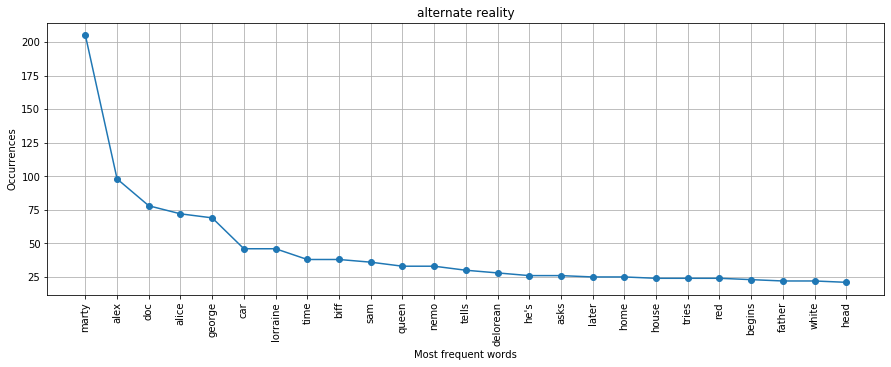

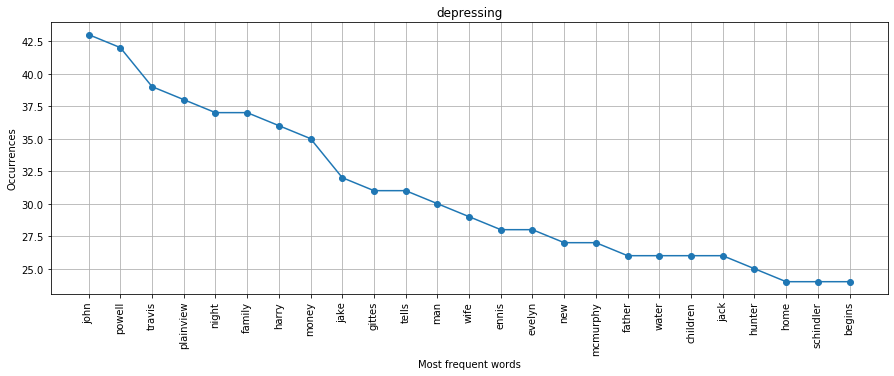

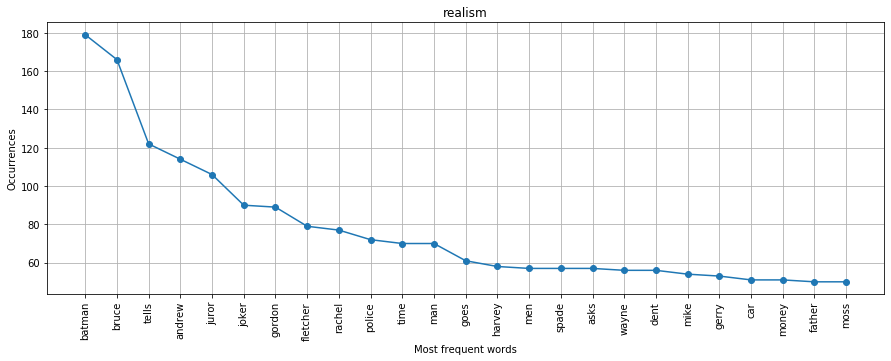

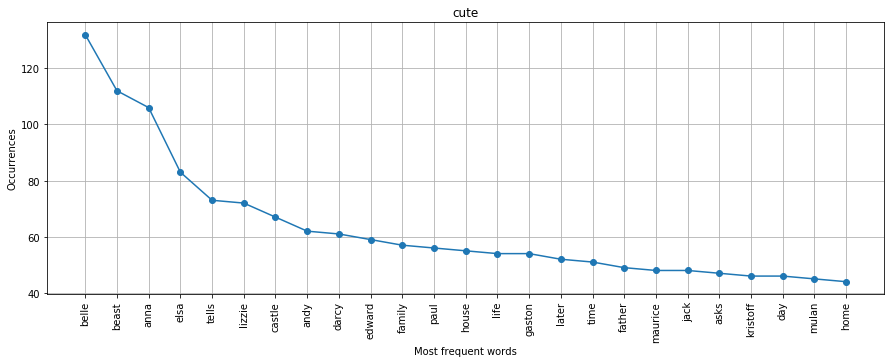

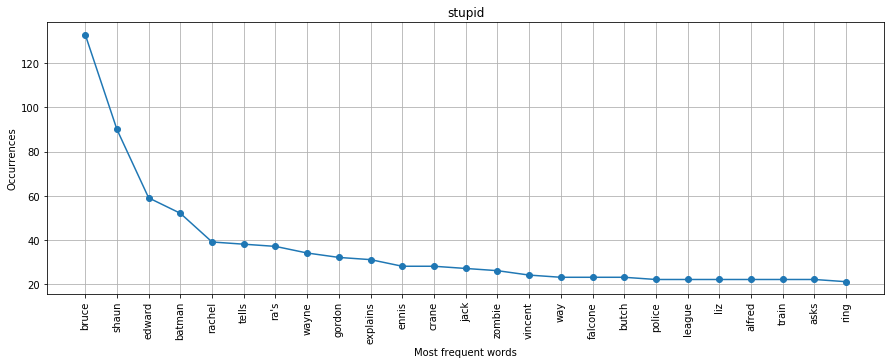

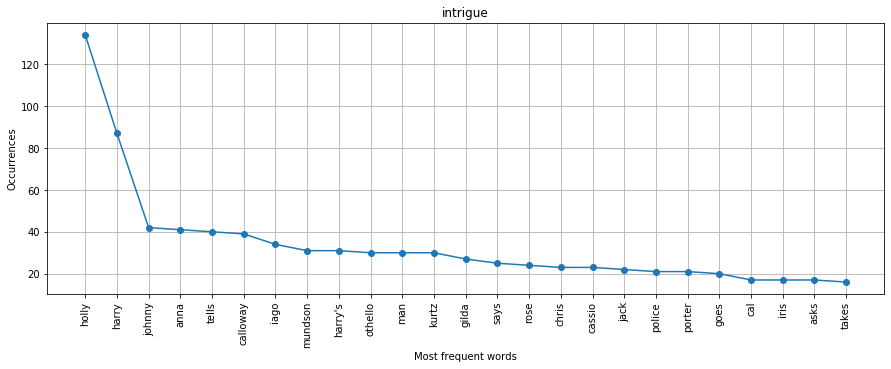

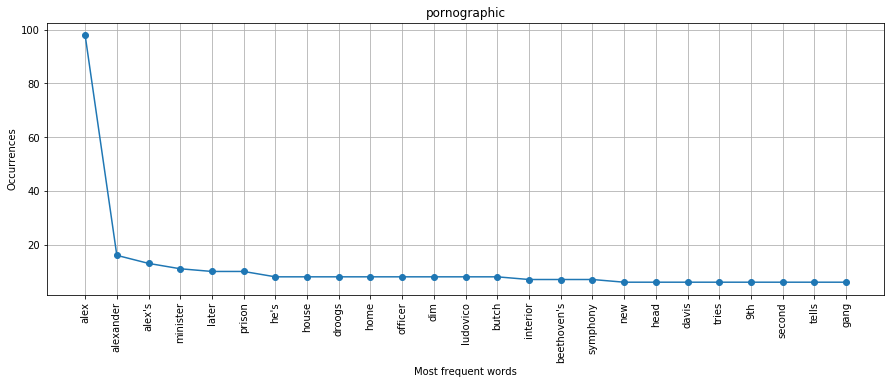

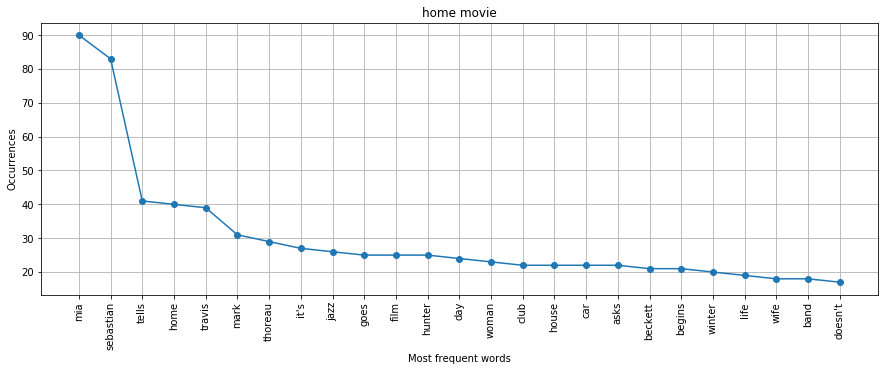

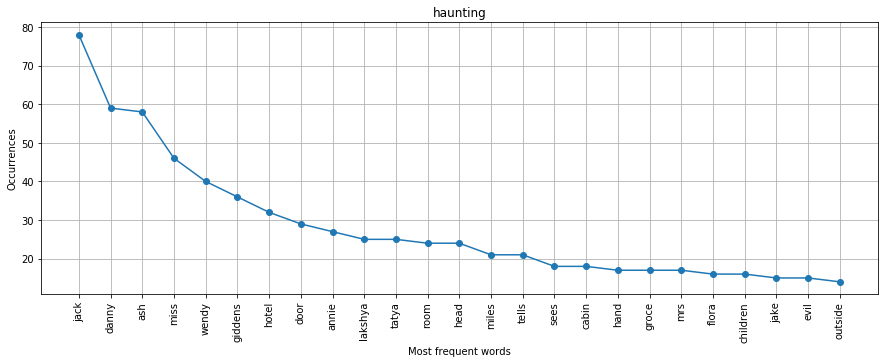

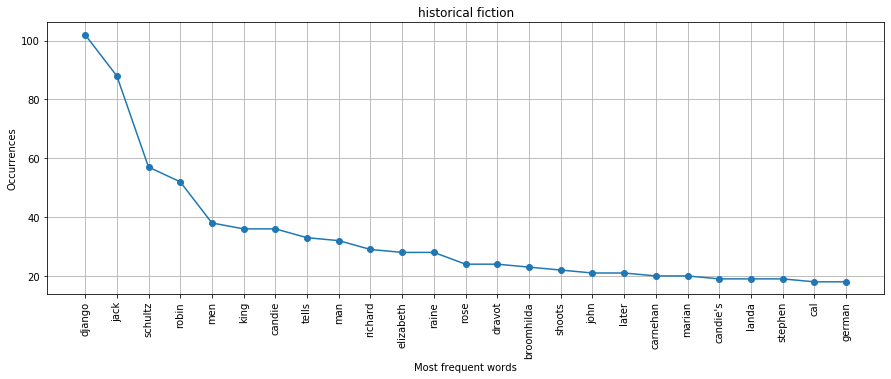

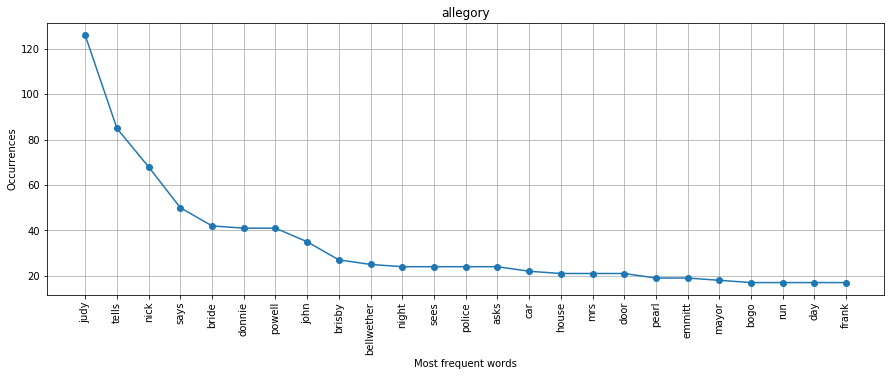

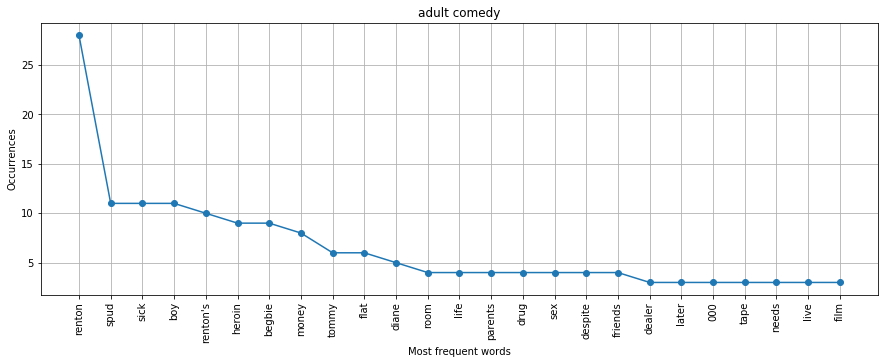

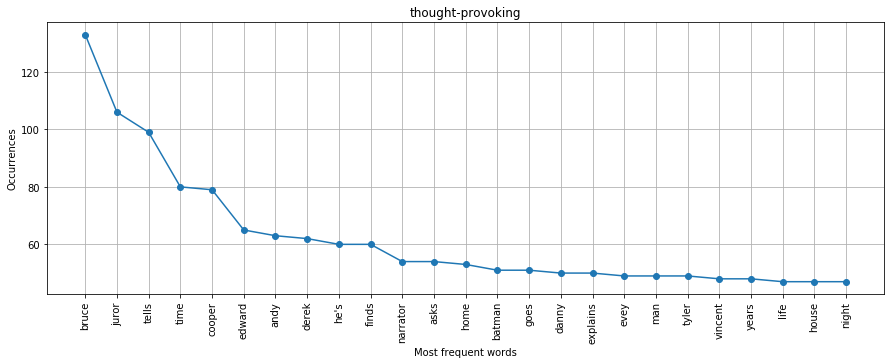

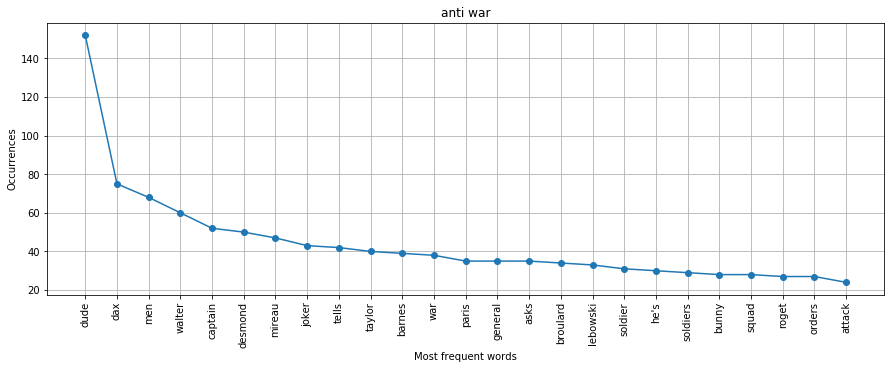

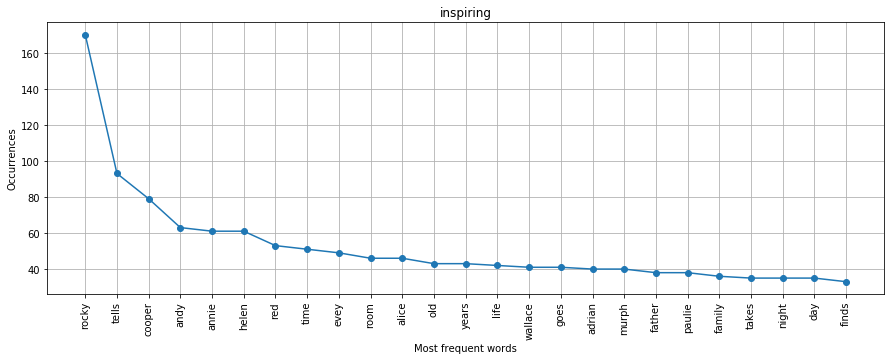

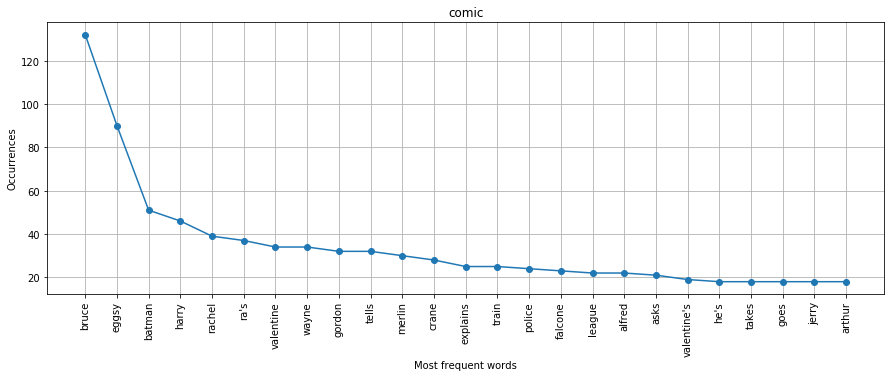

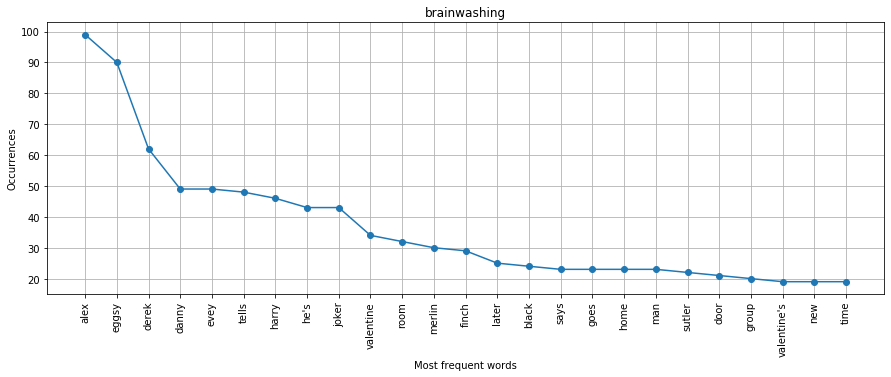

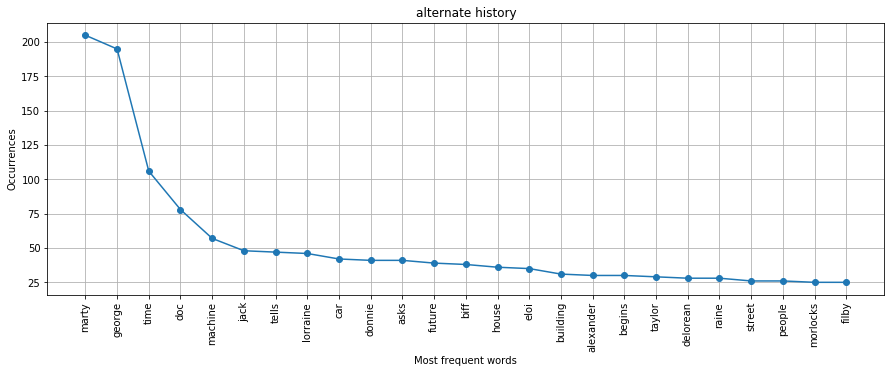

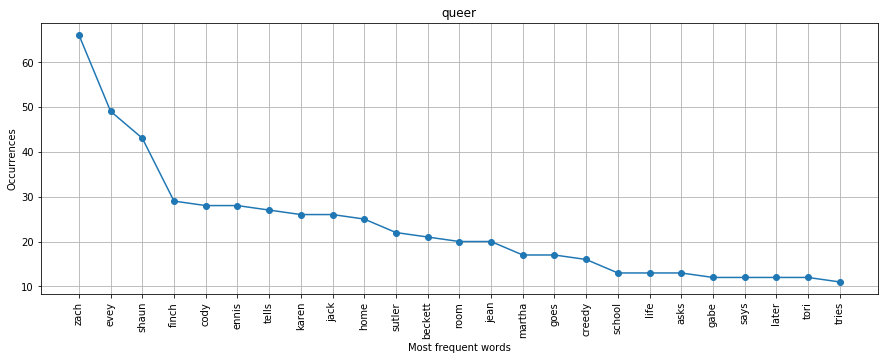

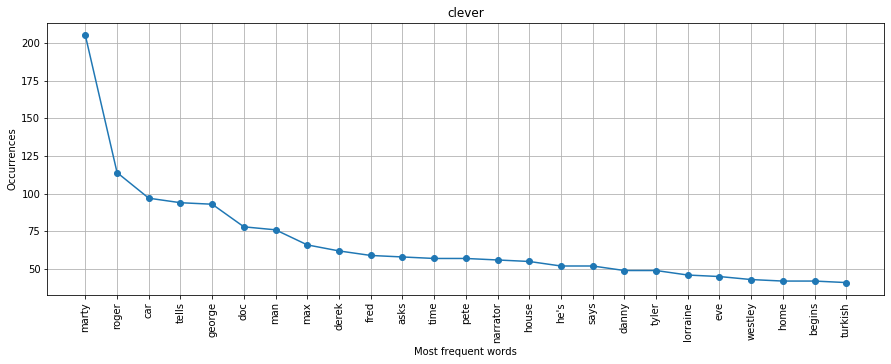

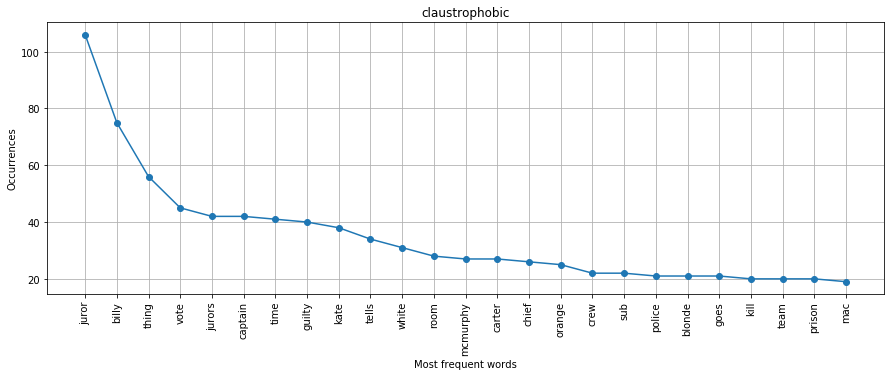

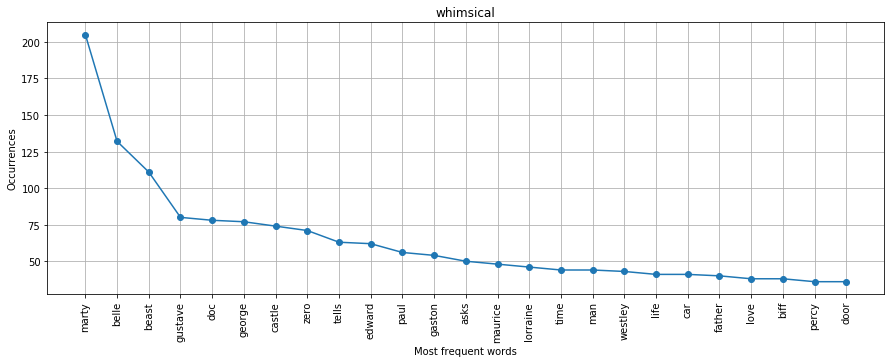

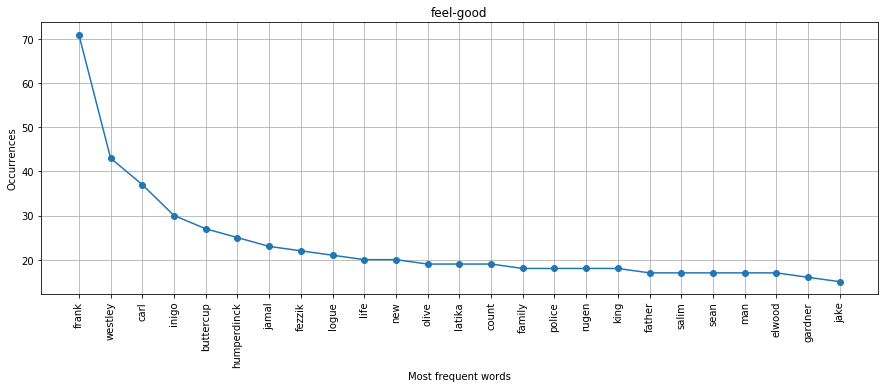

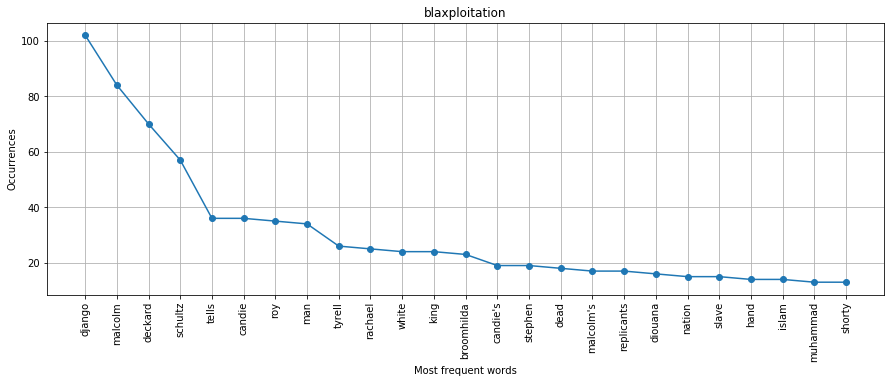

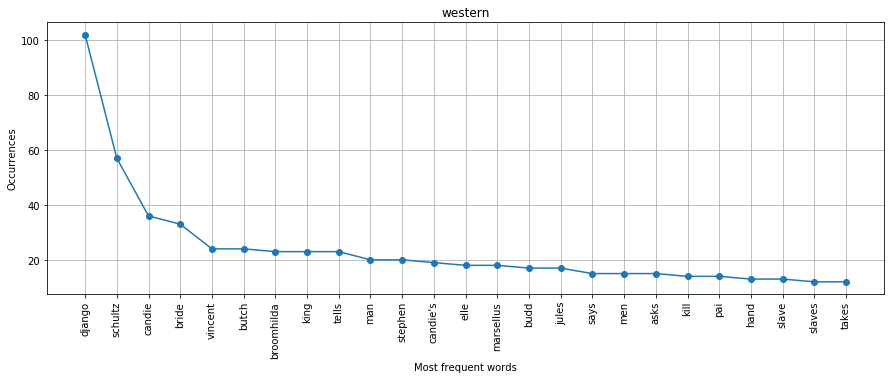

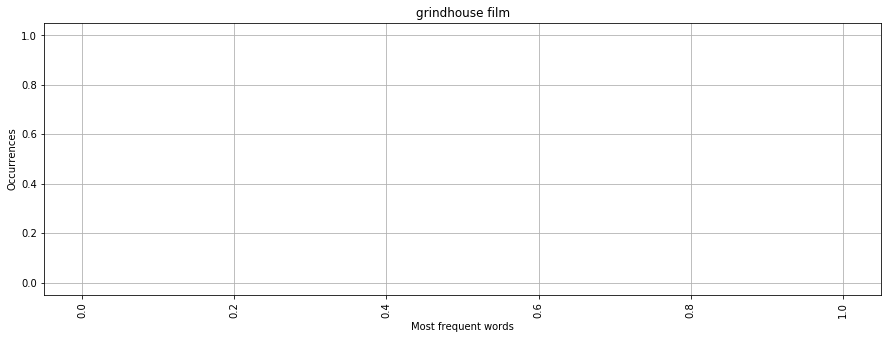

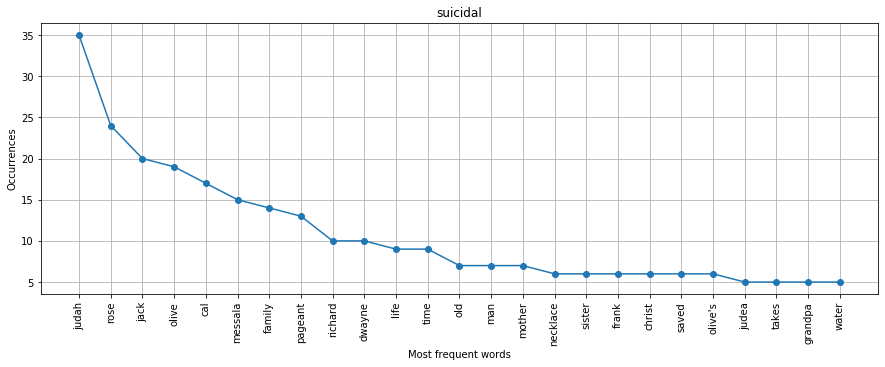

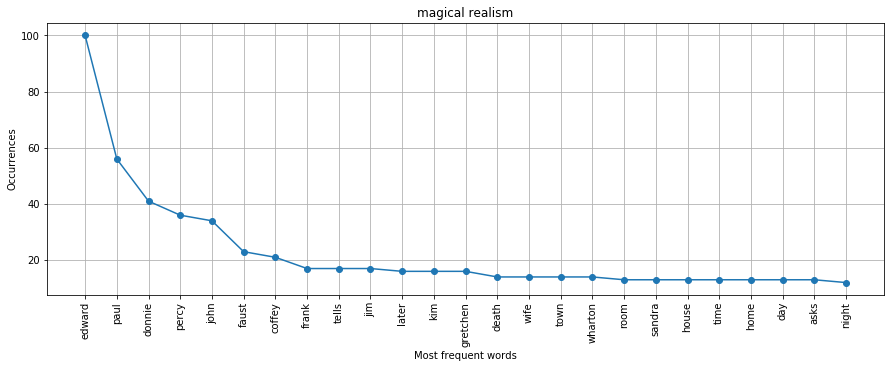

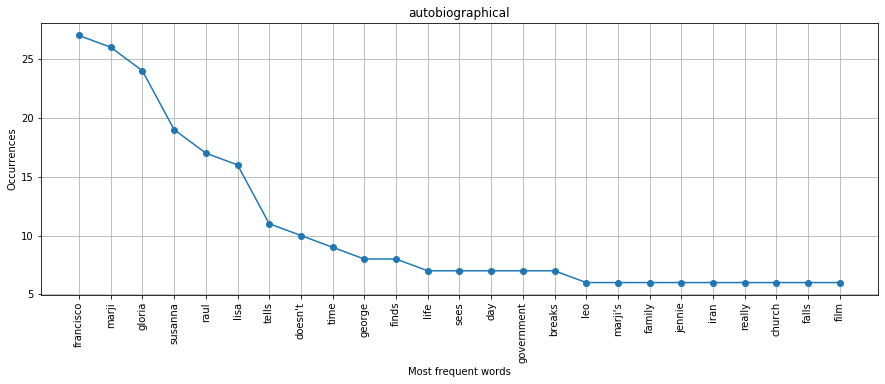

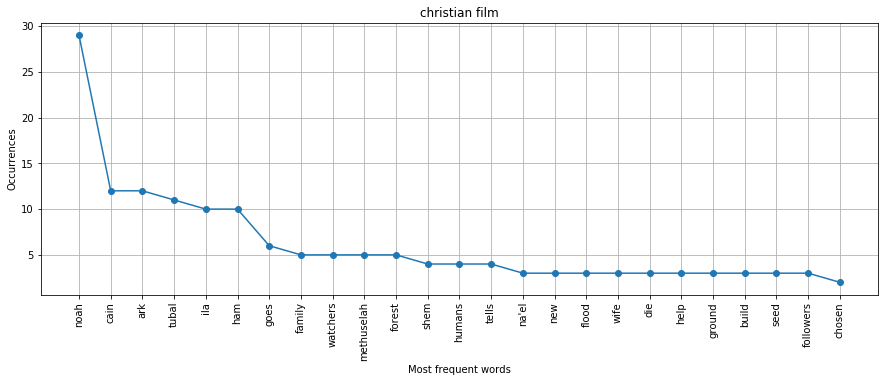

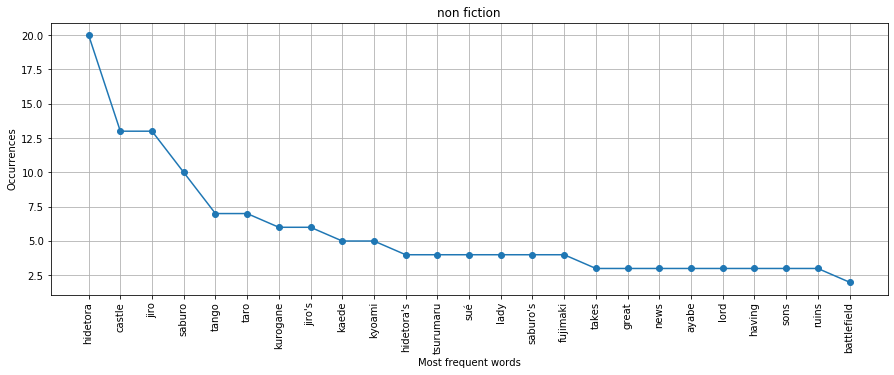

In [11]:
words_n = 25

for genre in words_dict:
    words = words_dict[genre]
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.plot([x[0] for x in words[:words_n]], [x[1] for x in words[:words_n]], marker='o')
    plt.xticks(rotation=90)
    plt.title(genre)
    plt.xlabel('Most frequent words')
    plt.ylabel('Occurrences')
    plt.show()

# Confronto tra due generi

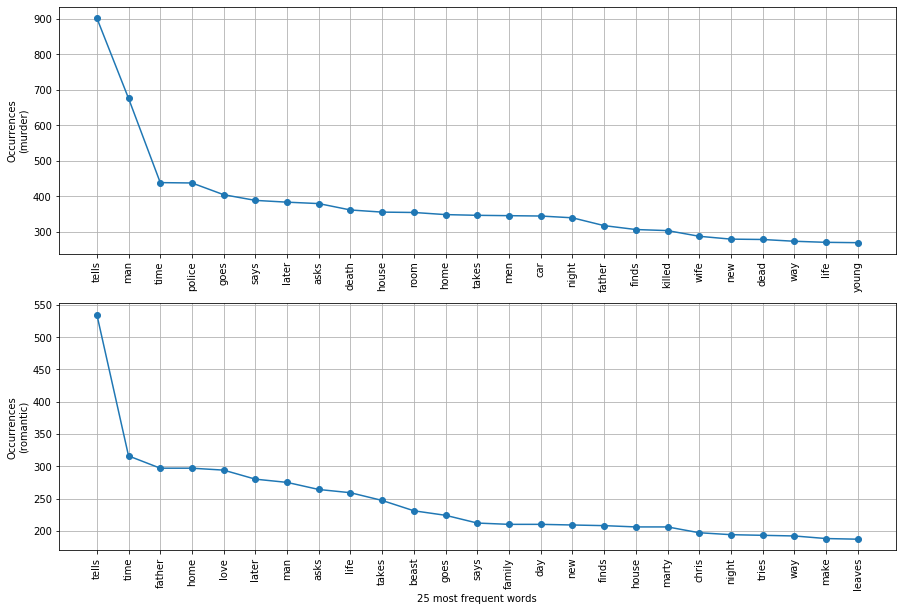

In [12]:
genre1 = 'murder'
genre2 = 'romantic'
words_n = 25

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot([x[0] for x in words_dict[genre1][:words_n]], [x[1] for x in words_dict[genre1][:words_n]], marker='o')
plt.xticks(rotation=90)
plt.ylabel('Occurrences\n(' + str(genre1) + ')')
plt.subplot(2, 1, 2)
plt.grid()
plt.plot([x[0] for x in words_dict[genre2][:words_n]], [x[1] for x in words_dict[genre2][:words_n]], marker='o')
plt.xticks(rotation=90)
plt.xlabel(str(words_n) + ' most frequent words')
plt.ylabel('Occurrences\n(' + str(genre2) + ')')
plt.show()

# Fine

In [13]:
sc.stop()